## Model description

This builds on `exponential_model.ipynb` by considering the generation interval distribution, i.e. the distribution in the time it takes for an infection to lead to another infection. The assumptions are as follows:

1. There is an initial number, `N_0`, of new infections on the 0th day.
2. Each infection is itself an infector, leading to `R_0` expected secondary infections. `R_0` is the basic reproduction number.
3. Number of days between a primary infection and its secondary infections follows the generation interval distribution.
4. A fraction (IFR, infection fatality rate) of new infections are expected to turn into deaths.
5. Deaths occur after an incubation period then a delay time from illness onset to death. These periods have predefined distributions, and the number of expected deaths on a given date is a convolution of the new infection over time with these 2 distributions.
6. Given the number of expected deaths on each day, the number of deaths is modeled as a Poisson process, and fit to the data.

Only the assumptions 2 and 3 are modified from the exponential model, but now the undetermined parameters are `N_0` and `R_0`, rather than `N_0` and the exponential coefficient of growth.

In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

import covid_19.covid_func as cf

Data source for Chicago:

https://www.chicago.gov/city/en/sites/covid-19/home/latest-data.html

Pickle file is created in `create_data_pickles.ipynb` notebook.

Note that these numbers for Chicago do get updated even more than a week after the fact. It appears that they are trying to record accurate dates for these deaths, rather than simply keeping track of when they were reported/announced. This is not always the case for other agencies.

In [2]:
death_df = pd.read_pickle('../data/chi_deaths.pickle')

In [3]:
death_df.iloc[-10:]

,deaths
2020-04-05,28
2020-04-06,15
2020-04-07,22
2020-04-08,30
2020-04-09,19
2020-04-10,23
2020-04-11,20
2020-04-12,24
2020-04-13,12
2020-04-14,1


In [4]:
# Drop later rows when it appears that they have not been updated fully
death_df = death_df.iloc[:-3]

In [5]:
num_days = len(death_df)

In [7]:
death_list = list(death_df['deaths'])

#### Do a convolution

Incubation period from https://www.mdpi.com/2077-0383/9/2/538:

Lognormal distribution with mean 5.6 days, SD 2.8 days.

In [8]:
# Use lognorm_pdf function defined in covid_func.py
mean_i = 5.6
sd_i = 2.8

incubation_pdf = cf.lognorm_pdf(mean_i, sd_i)

In [9]:
incubation_array = np.array([incubation_pdf(x) for x in range(num_days)])

Onset-to-death delay from https://www.sciencedirect.com/science/article/pii/S1473309920302437

Gamma function with mean 17.8 days, coefficient of variation 0.45.

In [10]:
# Use gamma_pdf function defined in covid_func.py
mean_d = 17.8
cov_d = 0.45
sd_d = mean_d * cov_d

delay_pdf = cf.gamma_pdf(mean_d, sd_d)

In [11]:
delay_array = np.array([delay_pdf(x) for x in range(num_days)])

Given an array of infections, create a transfer matrix that turns it in to an array of cases with symptoms. The function to do this is defined in `covid_func.py`.

This is not exactly correct, as it ignores asymptotic cases, but I will multiply the whole array by the infection fatality rate (IFR) so the final answer will be modeled correctly.

In [12]:
incubation_mat = cf.create_delay_matrix(incubation_array, num_days)

It looks like this.

In [13]:
incubation_mat[:5,:5]

array([[0.        , 0.00251436, 0.06388876, 0.15624861, 0.18851108],
       [0.        , 0.        , 0.00251436, 0.06388876, 0.15624861],
       [0.        , 0.        , 0.        , 0.00251436, 0.06388876],
       [0.        , 0.        , 0.        , 0.        , 0.00251436],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

Similarly

In [14]:
delay_mat = cf.create_delay_matrix(delay_array, num_days)

In [15]:
transfer_mat = np.matmul(incubation_mat, delay_mat)

#### Generation interval

Following https://www.medrxiv.org/content/10.1101/2020.03.05.20031815v1 (Table 3 for Singapore), I'll take the generation interval to be drawn from a Gamma distribution, with mean 3.86 days, SD 2.65 days.

This is one of the shorter estimates of the generation interval (or serial interval), and shorter generation intervals lead to faster growth for the same R_0. So, in terms of fitting to some data, assuming a shorter generation interval leads to a larger R_0.

In [18]:
mean_g = 3.86
sd_g = 2.65

generation_pdf = cf.gamma_pdf(mean_g, sd_g)

In [20]:
generation_array = np.array([generation_pdf(x)
                             for x in range(num_days)])

At first, you have an array of infections, `[N_0, 0, 0, ...]`. You then multiply by R0 * generation_array to get the new infections generated from that first patient.

Add these patients to the infections array, then you multiply the 2nd element by a shifted version of generation_array, to get the new infections from those people.

This requires a successive multiplication by matrices. `create_infection_tensor` is a 3 dimensional array whose n-th element is the n-th matrix required in this process.

In [26]:
def create_infection_tensor(num_days=num_days,
                            generation_array=generation_array):
    """Given num_days,
    return array of infection matrices so that
    multiplying the initial vector [1., 0., 0., ...]
    by result[0] * R0 and adding the last vector,
    multiplying by result[1] * R0 and adding the last vector, ... 
    recursively results in the predicted number of new infections for each day."""
    list_of_matrices = []
    for index in range(num_days):
        non_zero_row = np.concatenate([np.zeros(index),
                                       generation_array[:num_days-index]]).reshape((1, num_days))
        matrix = np.vstack([np.zeros((index, num_days)),
                            non_zero_row,
                            np.zeros((num_days - index - 1, num_days))])
        list_of_matrices.append(matrix)
    return np.stack(list_of_matrices)

Create a new model

In [27]:
infection_tensor = create_infection_tensor()

In [30]:
with pm.Model() as model:
    N_0 = pm.Exponential('initial', lam=1.)
    R_0 = pm.Normal('R_0', mu=3., sd=2.)
    N_array = N_0 * np.array([1.] + [0.] * (num_days - 1))
    
    for tensor in infection_tensor[:-1]:
        N_array += R_0 * pm.math.matrix_dot(N_array,
                                            tensor)
        
    IFR = 0.011
    
    exp_deaths = IFR * pm.math.matrix_dot(N_array,
                                          incubation_mat, 
                                          delay_mat)

In [31]:
with model:
    D = pm.Poisson('deaths', mu=exp_deaths, observed=death_list)

In [32]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, tune=10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R_0, initial]
Sampling 2 chains, 0 divergences: 100%|██████████| 40000/40000 [08:58<00:00, 74.22draws/s] 
The number of effective samples is smaller than 25% for some parameters.


/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


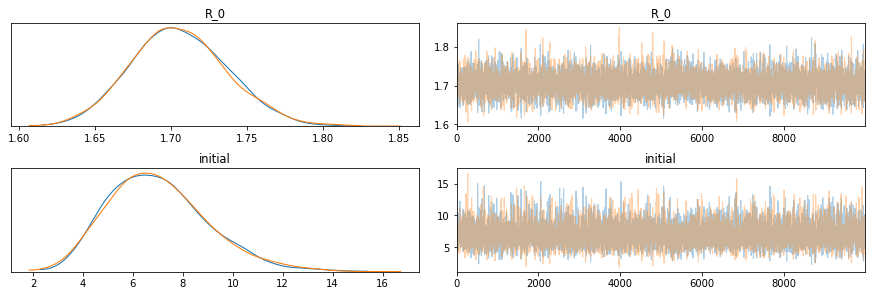

In [33]:
pm.traceplot(trace)
plt.show()

In [34]:
initial_array = np.array(trace['initial'])
R_0_array = np.array(trace['R_0'])

Create a function outside pymc to calculate prediction given N_0 and R_0.

In [35]:
def give_predicted_infections(N_0, R_0,
                              num_days=num_days):
    N_array = N_0 * np.array([1.] + [0.] * (num_days - 1))
    infection_tensor = create_infection_tensor(num_days)
    
    for tensor in infection_tensor[:-1]:
        N_array += R_0 * np.matmul(N_array, tensor)
        
    return N_array

In [36]:
median_N_0 = np.median(initial_array)
median_R_0 = np.median(R_0_array)

In [37]:
median_N_0

6.847677238407453

In [38]:
median_R_0

1.7041365118759917

In [39]:
median_pred = give_predicted_infections(N_0=median_N_0,
                                        R_0=median_R_0)

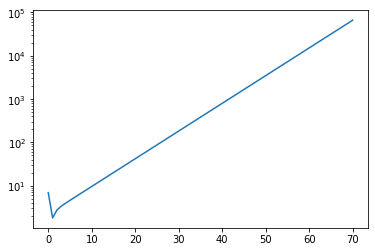

In [40]:
plt.plot(median_pred)
plt.yscale('log')
plt.show()

In [41]:
2.8e6 / median_pred[12 + 28]

3530.172638802189

Yep, this model also suggests a more than half an order of magnitude mistake for me.

In [42]:
def give_predicted_deaths(N_0, R_0, IFR=0.011,
                          incubation_mat=incubation_mat,
                          delay_mat=delay_mat,
                          num_days=num_days):
    N_array = give_predicted_infections(N_0=N_0, R_0=R_0,
                                        num_days=num_days)
    
    return IFR * np.matmul(np.matmul(N_array, incubation_mat),
                           delay_mat)

In [43]:
pred = give_predicted_deaths(median_N_0, median_R_0)

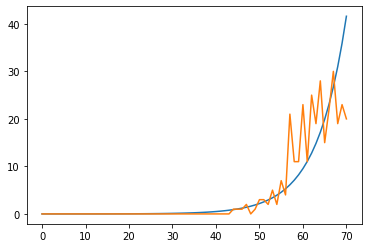

In [44]:
plt.plot(pred)
plt.plot(death_list)
plt.show()